# 05__mpranalyze_compare_crossrep

in this notebook, i run MPRAnalyze in 'compare' mode to get log2 foldchanges and p-values between (a) sequence orthologs and (b) cell types; this time *only* looking across replicates (rep1 in human/mouse for cis effects, rep2 in human/mouse for trans effects)

In [1]:
# # install MPRAnalyze
# if (!requireNamespace("BiocManager", quietly = TRUE))
#   install.packages("BiocManager")
# BiocManager::install("MPRAnalyze", version = "3.8")

In [2]:
# # install RCurl
# install.packages("RCurl")

In [3]:
# # install biocparallel
# if (!requireNamespace("BiocManager", quietly = TRUE))
#     install.packages("BiocManager")
# BiocManager::install("BiocParallel")

In [4]:
# load the package
library(MPRAnalyze)
library(tidyr)

In [5]:
library(BiocParallel)

## 1. load data

### first load data for library depth correction

In [6]:
dna_counts_depth <- read.table("../../../data/02__mpra/01__counts/mpranalyze_files/dna_counts.for_depth_estimation.mpranalyze.txt", sep="\t", header=TRUE)

# since we only have 1 dna replicate -- add another so code doesn't crash (expects matrix)
dna_counts_depth["dna_2"] <- dna_counts_depth["dna_1"]

row.names(dna_counts_depth) <- dna_counts_depth$element
dna_counts_depth <- dna_counts_depth[ , !(names(dna_counts_depth) %in% c("element")), drop=FALSE]
dna_counts_depth <- as.matrix(dna_counts_depth)

In [7]:
rna_counts_depth <- read.table("../../../data/02__mpra/01__counts/mpranalyze_files/rna_counts.for_depth_estimation.mpranalyze.txt", sep="\t", header=TRUE)
row.names(rna_counts_depth) <- rna_counts_depth$element
rna_counts_depth <- rna_counts_depth[ , !(names(rna_counts_depth) %in% c("element")), drop=FALSE]
rna_counts_depth <- as.matrix(rna_counts_depth)

In [8]:
dna_cols_depth <- read.table("../../../data/02__mpra/01__counts/mpranalyze_files/dna_col_ann.for_depth_estimation.mpranalyze.txt", sep="\t", header=TRUE)
names(dna_cols_depth) <- c("id", "condition", "sample")

# add second row to dna_cols_depth
row2 <- data.frame(id="dna_2", condition="dna", sample="2")
dna_cols_depth <- rbind(dna_cols_depth, row2)
row.names(dna_cols_depth) <- dna_cols_depth$id

rna_cols_depth <- read.table("../../../data/02__mpra/01__counts/mpranalyze_files/rna_col_ann.for_depth_estimation.mpranalyze.txt", sep="\t", header=TRUE)
names(rna_cols_depth) <- c("id", "condition", "sample")
row.names(rna_cols_depth) <- rna_cols_depth$id
rna_cols_depth

,id,condition,sample
,<fct>,<fct>,<int>
HUES64_rep1,HUES64_rep1,HUES64,1
HUES64_rep2,HUES64_rep2,HUES64,2
HUES64_rep3,HUES64_rep3,HUES64,3
mESC_rep1,mESC_rep1,mESC,1
mESC_rep2,mESC_rep2,mESC,2
mESC_rep3,mESC_rep3,mESC,3


In [9]:
# make sure everything is a factor
dna_cols_depth$condition <- as.factor(dna_cols_depth$condition)
rna_cols_depth$condition <- as.factor(rna_cols_depth$condition)
rna_cols_depth$sample <- as.factor(rna_cols_depth$sample)
rna_cols_depth

,id,condition,sample
,<fct>,<fct>,<fct>
HUES64_rep1,HUES64_rep1,HUES64,1
HUES64_rep2,HUES64_rep2,HUES64,2
HUES64_rep3,HUES64_rep3,HUES64,3
mESC_rep1,mESC_rep1,mESC,1
mESC_rep2,mESC_rep2,mESC,2
mESC_rep3,mESC_rep3,mESC,3


### then data to model: first, DNA (same for all models)

In [10]:
all_comp_dna_counts <- read.table("../../../data/02__mpra/01__counts/mpranalyze_files/dna_counts.all_comp.mpranalyze.txt", sep="\t", header=TRUE)
row.names(all_comp_dna_counts) <- all_comp_dna_counts$comp_id
all_comp_dna_counts <- all_comp_dna_counts[ , !(names(all_comp_dna_counts) %in% c("comp_id"))]
all_comp_dna_counts <- as.matrix(all_comp_dna_counts)

In [11]:
all_comp_dna_cols <- read.table("../../../data/02__mpra/01__counts/mpranalyze_files/dna_col_ann.all_comp.mpranalyze.txt", sep="\t", header=TRUE)
row.names(all_comp_dna_cols) <- all_comp_dna_cols$X
head(all_comp_dna_cols)

,X,condition,barcode,seq
,<fct>,<fct>,<int>,<fct>
samp:dna_1__barc:10___seq:human,samp:dna_1__barc:10___seq:human,dna,10,human
samp:dna_1__barc:10___seq:mouse,samp:dna_1__barc:10___seq:mouse,dna,10,mouse
samp:dna_1__barc:11___seq:human,samp:dna_1__barc:11___seq:human,dna,11,human
samp:dna_1__barc:11___seq:mouse,samp:dna_1__barc:11___seq:mouse,dna,11,mouse
samp:dna_1__barc:12___seq:human,samp:dna_1__barc:12___seq:human,dna,12,human
samp:dna_1__barc:12___seq:mouse,samp:dna_1__barc:12___seq:mouse,dna,12,mouse


In [12]:
all_comp_dna_cols$barcode <- as.factor(all_comp_dna_cols$barcode)
all_comp_dna_cols$seq <- as.factor(all_comp_dna_cols$seq)
all_comp_dna_cols$condition <- as.factor(all_comp_dna_cols$condition)
all_comp_dna_cols

,X,condition,barcode,seq
,<fct>,<fct>,<fct>,<fct>
samp:dna_1__barc:10___seq:human,samp:dna_1__barc:10___seq:human,dna,10,human
samp:dna_1__barc:10___seq:mouse,samp:dna_1__barc:10___seq:mouse,dna,10,mouse
samp:dna_1__barc:11___seq:human,samp:dna_1__barc:11___seq:human,dna,11,human
samp:dna_1__barc:11___seq:mouse,samp:dna_1__barc:11___seq:mouse,dna,11,mouse
samp:dna_1__barc:12___seq:human,samp:dna_1__barc:12___seq:human,dna,12,human
samp:dna_1__barc:12___seq:mouse,samp:dna_1__barc:12___seq:mouse,dna,12,mouse
samp:dna_1__barc:13___seq:human,samp:dna_1__barc:13___seq:human,dna,13,human
samp:dna_1__barc:13___seq:mouse,samp:dna_1__barc:13___seq:mouse,dna,13,mouse
samp:dna_1__barc:1___seq:human,samp:dna_1__barc:1___seq:human,dna,1,human


### then controls (same for all models)

In [13]:
all_comp_ctrls <- read.table("../../../data/02__mpra/01__counts/mpranalyze_files/ctrl_status.all_comp.mpranalyze.txt", sep="\t", header=TRUE)
all_comp_ctrls <- as.logical(all_comp_ctrls$ctrl_status)
head(all_comp_ctrls)

[1] FALSE FALSE FALSE FALSE FALSE FALSE

In [14]:
length(all_comp_ctrls)

[1] 3334

### human/mouse data for cis effects in each cell line

In [15]:
# for seq comparisons, load each cell line data separately
hues64_rna_counts <- read.table("../../../data/02__mpra/01__counts/mpranalyze_files/HUES64_rna_counts.seq_comp.REP1_ONLY.mpranalyze.txt", sep="\t", header=TRUE)
row.names(hues64_rna_counts) <- hues64_rna_counts$comp_id
hues64_rna_counts <- hues64_rna_counts[ , !(names(hues64_rna_counts) %in% c("comp_id"))]
hues64_rna_counts <- as.matrix(hues64_rna_counts)

mesc_rna_counts <- read.table("../../../data/02__mpra/01__counts/mpranalyze_files/mESC_rna_counts.seq_comp.REP1_ONLY.mpranalyze.txt", sep="\t", header=TRUE)
row.names(mesc_rna_counts) <- mesc_rna_counts$comp_id
mesc_rna_counts <- mesc_rna_counts[ , !(names(mesc_rna_counts) %in% c("comp_id"))]
mesc_rna_counts <- as.matrix(mesc_rna_counts)

In [16]:
hues64_rna_cols <- read.table("../../../data/02__mpra/01__counts/mpranalyze_files/HUES64_col_ann.seq_comp.REP1_ONLY.mpranalyze.txt", sep="\t", header=TRUE)
row.names(hues64_rna_cols) <- hues64_rna_cols$X

mesc_rna_cols <- read.table("../../../data/02__mpra/01__counts/mpranalyze_files/mESC_col_ann.seq_comp.REP1_ONLY.mpranalyze.txt", sep="\t", header=TRUE)
row.names(mesc_rna_cols) <- mesc_rna_cols$X

In [17]:
# make sure everything is a factor
hues64_rna_cols$barcode <- as.factor(hues64_rna_cols$barcode)
mesc_rna_cols$barcode <- as.factor(mesc_rna_cols$barcode)

hues64_rna_cols$seq <- as.factor(hues64_rna_cols$seq)
mesc_rna_cols$seq <- as.factor(mesc_rna_cols$seq)

hues64_rna_cols$condition <- as.factor(hues64_rna_cols$condition)
mesc_rna_cols$condition <- as.factor(mesc_rna_cols$condition)

head(hues64_rna_cols)

,X,index,condition,barcode,seq
,<fct>,<fct>,<fct>,<fct>,<fct>
samp:HUES64_rep1__barc:10___seq:human,samp:HUES64_rep1__barc:10___seq:human,samp:HUES64_rep1__barc:10___seq:human,HUES64,10,human
samp:HUES64_rep1__barc:10___seq:mouse,samp:HUES64_rep1__barc:10___seq:mouse,samp:HUES64_rep1__barc:10___seq:mouse,HUES64,10,mouse
samp:HUES64_rep1__barc:11___seq:human,samp:HUES64_rep1__barc:11___seq:human,samp:HUES64_rep1__barc:11___seq:human,HUES64,11,human
samp:HUES64_rep1__barc:11___seq:mouse,samp:HUES64_rep1__barc:11___seq:mouse,samp:HUES64_rep1__barc:11___seq:mouse,HUES64,11,mouse
samp:HUES64_rep1__barc:12___seq:human,samp:HUES64_rep1__barc:12___seq:human,samp:HUES64_rep1__barc:12___seq:human,HUES64,12,human
samp:HUES64_rep1__barc:12___seq:mouse,samp:HUES64_rep1__barc:12___seq:mouse,samp:HUES64_rep1__barc:12___seq:mouse,HUES64,12,mouse


### human/mouse data for trans effects of each sequence

In [18]:
# for cell comparisons, load each cell line data separately
human_rna_counts <- read.table("../../../data/02__mpra/01__counts/mpranalyze_files/human_rna_counts.cell_comp.REP2_ONLY.mpranalyze.txt", sep="\t", header=TRUE)
row.names(human_rna_counts) <- human_rna_counts$comp_id
human_rna_counts <- human_rna_counts[ , !(names(human_rna_counts) %in% c("comp_id"))]
human_rna_counts <- as.matrix(human_rna_counts)

mouse_rna_counts <- read.table("../../../data/02__mpra/01__counts/mpranalyze_files/mouse_rna_counts.cell_comp.REP2_ONLY.mpranalyze.txt", sep="\t", header=TRUE)
row.names(mouse_rna_counts) <- mouse_rna_counts$comp_id
mouse_rna_counts <- mouse_rna_counts[ , !(names(mouse_rna_counts) %in% c("comp_id"))]
mouse_rna_counts <- as.matrix(mouse_rna_counts)

In [19]:
human_rna_cols <- read.table("../../../data/02__mpra/01__counts/mpranalyze_files/human_col_ann.cell_comp.REP2_ONLY.mpranalyze.txt", sep="\t", header=TRUE)
row.names(human_rna_cols) <- human_rna_cols$X

mouse_rna_cols <- read.table("../../../data/02__mpra/01__counts/mpranalyze_files/mouse_col_ann.cell_comp.REP2_ONLY.mpranalyze.txt", sep="\t", header=TRUE)
row.names(mouse_rna_cols) <- mouse_rna_cols$X

In [20]:
# make sure everything is a factor
human_rna_cols$barcode <- as.factor(human_rna_cols$barcode)
mouse_rna_cols$barcode <- as.factor(mouse_rna_cols$barcode)

human_rna_cols$seq <- as.factor(human_rna_cols$seq)
mouse_rna_cols$seq <- as.factor(mouse_rna_cols$seq)

human_rna_cols$condition <- as.factor(human_rna_cols$condition)
mouse_rna_cols$condition <- as.factor(mouse_rna_cols$condition)

head(human_rna_cols)

index,condition,barcode,seq
<fct>,<fct>,<fct>,<fct>
samp:HUES64_rep2__barc:10___seq:human,HUES64,10,human
samp:HUES64_rep2__barc:11___seq:human,HUES64,11,human
samp:HUES64_rep2__barc:12___seq:human,HUES64,12,human
samp:HUES64_rep2__barc:13___seq:human,HUES64,13,human
samp:HUES64_rep2__barc:1___seq:human,HUES64,1,human
samp:HUES64_rep2__barc:2___seq:human,HUES64,2,human


## 2. estimate library depth for sample/condition pair

since our library has many more sequences than just the TSSs we want to model, estimate the library depth based on the full seq output (or downsampled counts, in HUES64 case), then manually provide this estimation to the model

In [21]:
# create MPRA object
depth_obj <- MpraObject(dnaCounts = dna_counts_depth, rnaCounts = rna_counts_depth, 
                        dnaAnnot = dna_cols_depth, rnaAnnot = rna_cols_depth)

In [22]:
# estimate depth factors using uq -- here, a sample/condition pair == 1 library
depth_obj <- estimateDepthFactors(depth_obj, lib.factor = c("sample", "condition"),  depth.estimator='uq',
                                  which.lib = "dna")
depth_obj <- estimateDepthFactors(depth_obj, lib.factor = c("id"),  
                                  depth.estimator='uq', which.lib = "rna")

In [23]:
rna_depths <- rnaDepth(depth_obj)
rna_depths

[1] 1.0000000 0.6751932 0.7720110 0.3075865 0.3853071 0.3660570

In [24]:
rna_cols_depth$depth <- rna_depths
rna_cols_depth

,id,condition,sample,depth
,<fct>,<fct>,<fct>,<dbl>
HUES64_rep1,HUES64_rep1,HUES64,1,1.0000000
HUES64_rep2,HUES64_rep2,HUES64,2,0.6751932
HUES64_rep3,HUES64_rep3,HUES64,3,0.7720110
mESC_rep1,mESC_rep1,mESC,1,0.3075865
mESC_rep2,mESC_rep2,mESC,2,0.3853071
mESC_rep3,mESC_rep3,mESC,3,0.3660570


## 3. run model to compare seqs in HUES64

In [25]:
# first need to set the dnadepths and rnadepths manually
all_comp_dna_cols$depth <- rep(1, nrow(all_comp_dna_cols))

In [26]:
hues64_depths <- rna_depths[1]
hues64_depths

[1] 1

In [27]:
# note 13 will change depending how many barcodes there are per element
hues64_rna_cols$depth <- rep(hues64_depths, each=26)

In [28]:
# create MPRA object
obj2 <- MpraObject(dnaCounts = all_comp_dna_counts, rnaCounts = hues64_rna_counts, 
                   dnaAnnot = all_comp_dna_cols, rnaAnnot = hues64_rna_cols, controls = all_comp_ctrls,
                   BPPARAM = SnowParam(workers=16,type="SOCK"))

In [29]:
obj2 <- setDepthFactors(obj2, dnaDepth = all_comp_dna_cols$depth, rnaDepth = hues64_rna_cols$depth)

In [30]:
obj2 <- analyzeComparative(obj = obj2, 
                           dnaDesign = ~ barcode, 
                           rnaDesign = ~ seq, 
                           reducedDesign = ~ 1) 

Fitting controls-based background model...
iter:2	log-likelihood:-35829056.0121772
iter:3	log-likelihood:-35791382.0228928
iter:4	log-likelihood:-35793299.3653865
Fitting model...
Fitting reduced model...
Analysis Done!


In [31]:
hues64_res <- testLrt(obj2)
head(hues64_res)

Performing Likelihood Ratio Test...


,statistic,pval,fdr,df.test,df.dna,df.rna.full,df.rna.red,logFC
,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
h.2__divergent__m.1__divergent__tile1,0.02886282,0.8650961624,0.921773923,1,14,5,4,-0.07479941
h.3__divergent__m.2__antisense__tile1,9.59354622,0.0019526246,0.010689738,1,13,5,4,2.19354326
h.4__antisense__m.3__protein_coding__tile1,0.62732174,0.4283394210,0.591688719,1,14,5,4,0.34853014
h.5__intergenic__m.4__intergenic__tile1,1.26797168,0.2601475364,0.421648948,1,14,5,4,-0.46521361
h.6__intergenic__m.4__intergenic__tile1,13.57935968,0.0002286862,0.002001155,1,14,5,4,-1.49194880
h.7__divergent__m.5__divergent__tile1,0.35738085,0.5499644568,0.697547826,1,14,5,4,-0.20305842


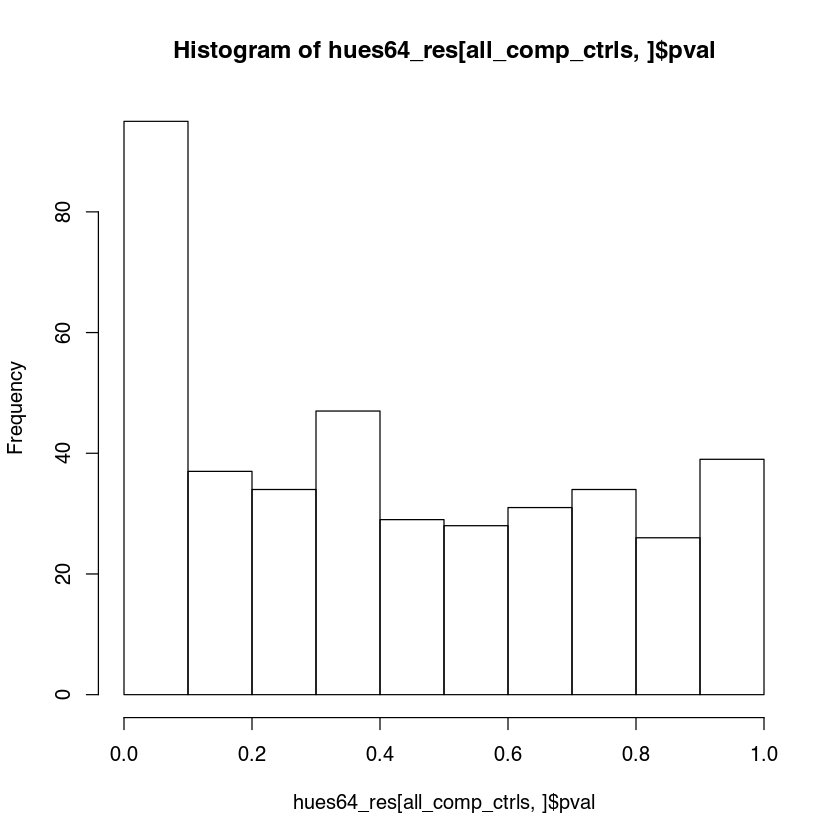

In [32]:
hist(hues64_res[all_comp_ctrls,]$pval)

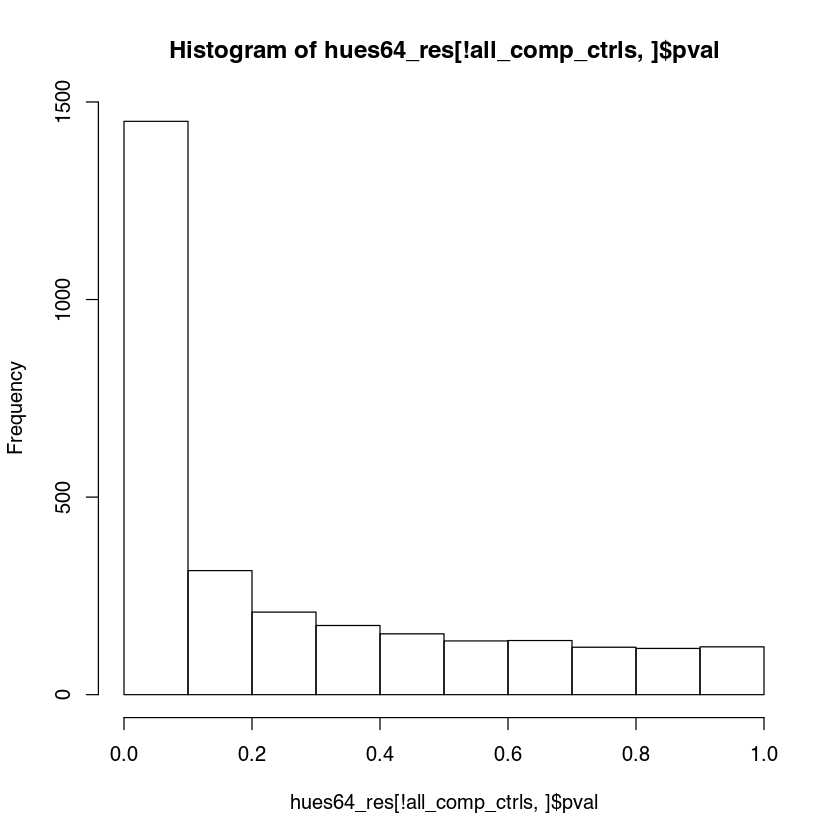

In [33]:
hist(hues64_res[!all_comp_ctrls,]$pval)

In [34]:
write.table(hues64_res, file = "../../../data/02__mpra/02__activs/HUES64_cis_results.REP1_ONLY.txt", sep = "\t",
            quote = FALSE)

## 6. run model to compare seqs in mESC

In [35]:
# note 13 will change depending how many barcodes there are per element
mesc_depths <- rna_depths[4]
mesc_rna_cols$depth <- rep(mesc_depths, each=26)

In [36]:
# create MPRA object
obj3 <- MpraObject(dnaCounts = all_comp_dna_counts, rnaCounts = mesc_rna_counts, 
                   dnaAnnot = all_comp_dna_cols, rnaAnnot = mesc_rna_cols, controls = all_comp_ctrls,
                   BPPARAM = SnowParam(workers=16,type="SOCK"))

In [37]:
obj3 <- setDepthFactors(obj3, dnaDepth = all_comp_dna_cols$depth, rnaDepth = mesc_rna_cols$depth)

In [38]:
obj3 <- analyzeComparative(obj = obj3, 
                           dnaDesign = ~ barcode, 
                           rnaDesign = ~ seq, 
                           reducedDesign = ~ 1) 

Fitting controls-based background model...
iter:2	log-likelihood:-30657231.5674809
iter:3	log-likelihood:-30667525.4071747
Fitting model...
Fitting reduced model...
Analysis Done!


In [39]:
mesc_res <- testLrt(obj3)
head(mesc_res)

Performing Likelihood Ratio Test...


,statistic,pval,fdr,df.test,df.dna,df.rna.full,df.rna.red,logFC
,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
h.2__divergent__m.1__divergent__tile1,0.1692845,6.807485e-01,8.015160e-01,1,14,5,4,-0.17747722
h.3__divergent__m.2__antisense__tile1,0.9402307,3.322185e-01,5.051894e-01,1,13,5,4,0.74795334
h.4__antisense__m.3__protein_coding__tile1,0.1300523,7.183778e-01,8.293184e-01,1,14,5,4,-0.15604617
h.5__intergenic__m.4__intergenic__tile1,8.6257982,3.314352e-03,1.782266e-02,1,14,5,4,-1.07974902
h.6__intergenic__m.4__intergenic__tile1,21.7006499,3.186833e-06,9.659001e-05,1,14,5,4,-1.87216139
h.7__divergent__m.5__divergent__tile1,0.0166951,8.971918e-01,9.403451e-01,1,14,5,4,0.03988508


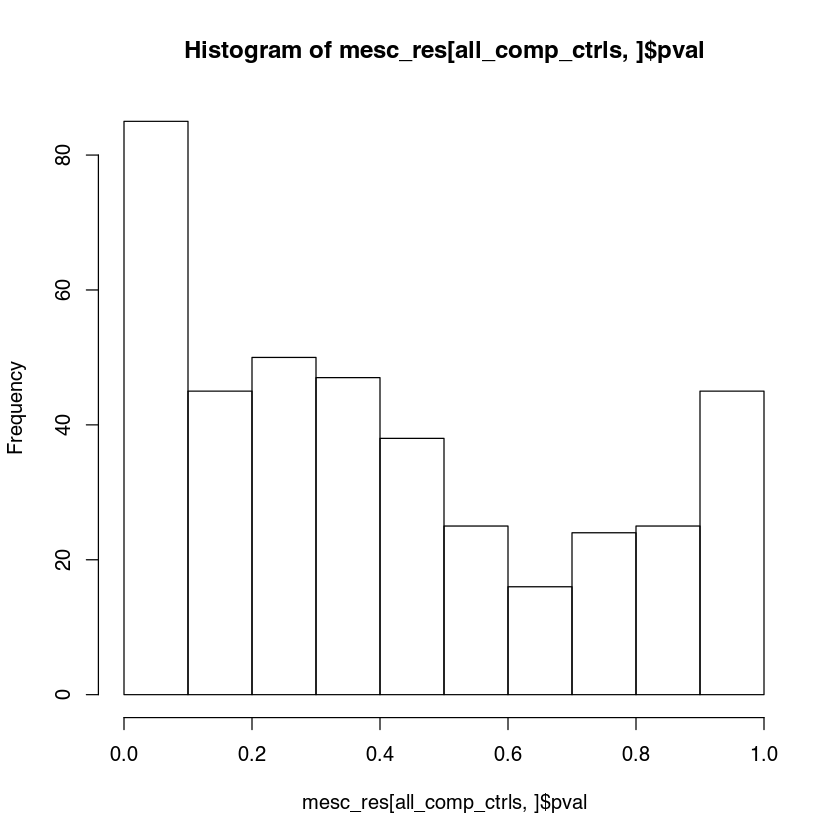

In [40]:
hist(mesc_res[all_comp_ctrls,]$pval)

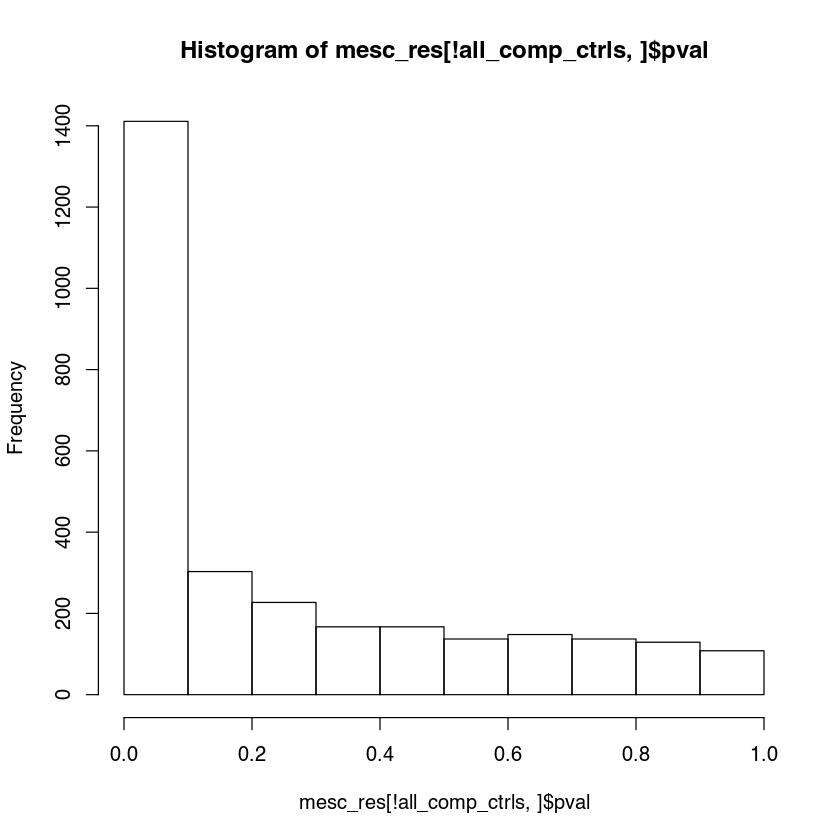

In [41]:
hist(mesc_res[!all_comp_ctrls,]$pval)

In [42]:
write.table(mesc_res, file = "../../../data/02__mpra/02__activs/mESC_cis_results.REP1_ONLY.txt", sep = "\t",
            quote = FALSE)

## 7. run model to compare cells for human seq

In [43]:
rna_depths

[1] 1.0000000 0.6751932 0.7720110 0.3075865 0.3853071 0.3660570

In [44]:
# note 13 will change depending how many barcodes there are per element
human_rna_cols$depth <- rep(rna_depths[2], each=13)

In [45]:
# create MPRA object
obj4 <- MpraObject(dnaCounts = all_comp_dna_counts, rnaCounts = human_rna_counts, 
                   dnaAnnot = all_comp_dna_cols, rnaAnnot = human_rna_cols, controls = all_comp_ctrls,
                   BPPARAM = SnowParam(workers=16,type="SOCK"))

In [46]:
obj4 <- setDepthFactors(obj4, dnaDepth = all_comp_dna_cols$depth, rnaDepth = human_rna_cols$depth)

In [47]:
obj4 <- analyzeComparative(obj = obj4, 
                           dnaDesign = ~ barcode, 
                           rnaDesign = ~ condition, 
                           reducedDesign = ~ 1) 

Fitting controls-based background model...
iter:2	log-likelihood:-32019117.4724921
iter:3	log-likelihood:-31904778.7367229
iter:4	log-likelihood:-31920953.0907552
Fitting model...
Fitting reduced model...
Analysis Done!


In [48]:
human_trans_res <- testLrt(obj4)
head(human_trans_res)

Performing Likelihood Ratio Test...


,statistic,pval,fdr,df.test,df.dna,df.rna.full,df.rna.red,logFC
,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
h.2__divergent__m.1__divergent__tile1,1.505119279,0.21988535,0.6642064,1,14,5,4,-0.42616110
h.3__divergent__m.2__antisense__tile1,0.002613054,0.95923146,0.9863601,1,13,5,4,0.03062416
h.4__antisense__m.3__protein_coding__tile1,0.535962935,0.46411065,0.8239323,1,14,5,4,0.27988063
h.5__intergenic__m.4__intergenic__tile1,3.564817663,0.05901622,0.4618781,1,14,5,4,0.45665868
h.6__intergenic__m.4__intergenic__tile1,0.966489226,0.32555732,0.7398828,1,14,5,4,0.26302615
h.7__divergent__m.5__divergent__tile1,0.176181661,0.67467541,0.9050713,1,14,5,4,-0.08067744


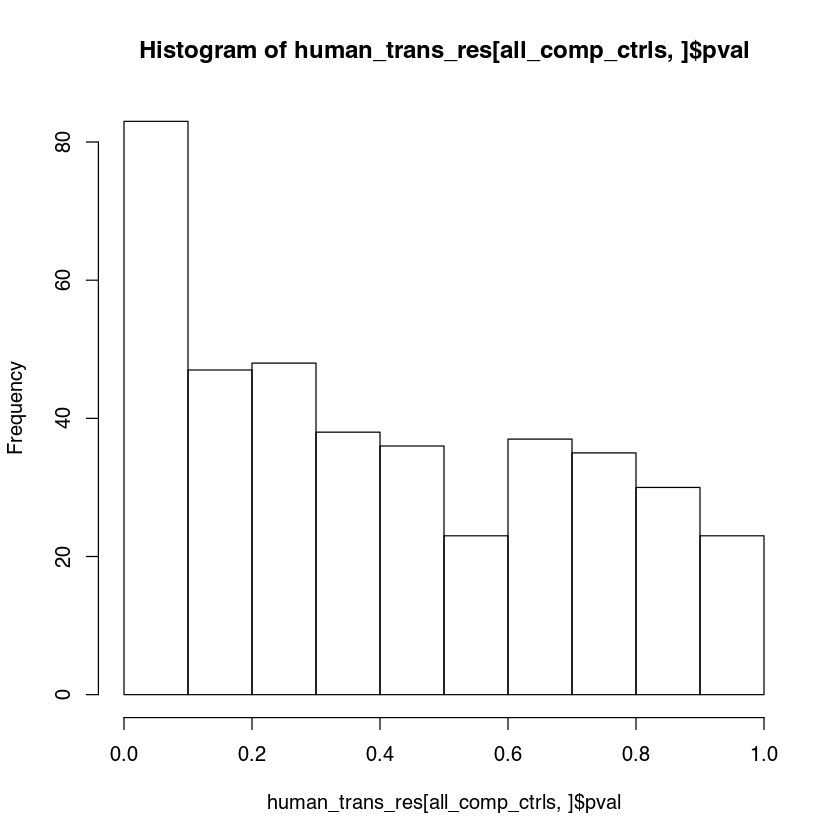

In [49]:
hist(human_trans_res[all_comp_ctrls,]$pval)

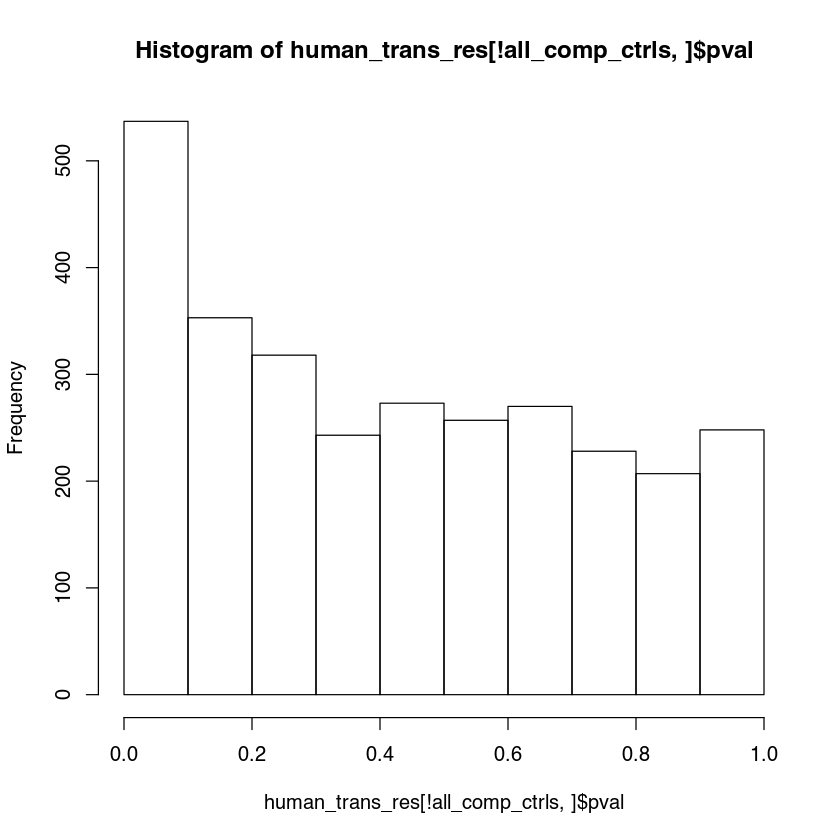

In [50]:
hist(human_trans_res[!all_comp_ctrls,]$pval)

In [51]:
write.table(human_trans_res, file = "../../../data/02__mpra/02__activs/human_trans_results.REP2_ONLY.txt", sep = "\t",
            quote = FALSE)

## 8. run model to compare cells for mouse seq

In [52]:
# note 13 will change depending how many barcodes there are per element
mouse_rna_cols$depth <- rep(rna_depths[5], each=13)

In [53]:
# create MPRA object
obj5 <- MpraObject(dnaCounts = all_comp_dna_counts, rnaCounts = mouse_rna_counts, 
                   dnaAnnot = all_comp_dna_cols, rnaAnnot = mouse_rna_cols, controls = all_comp_ctrls,
                   BPPARAM = SnowParam(workers=16,type="SOCK"))

In [54]:
obj5 <- setDepthFactors(obj5, dnaDepth = all_comp_dna_cols$depth, rnaDepth = mouse_rna_cols$depth)

In [55]:
obj5 <- analyzeComparative(obj = obj5, 
                           dnaDesign = ~ barcode, 
                           rnaDesign = ~ condition, 
                           reducedDesign = ~ 1) 

Fitting controls-based background model...
iter:2	log-likelihood:-32103879.1286656
iter:3	log-likelihood:-31911581.9449138
iter:4	log-likelihood:-31871821.6063305
iter:5	log-likelihood:-31869580.5982978
iter:6	log-likelihood:-31887357.5447702
Fitting model...
Fitting reduced model...
Analysis Done!


In [56]:
mouse_trans_res <- testLrt(obj5)
head(mouse_trans_res)

Performing Likelihood Ratio Test...


,statistic,pval,fdr,df.test,df.dna,df.rna.full,df.rna.red,logFC
,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
h.2__divergent__m.1__divergent__tile1,1.0391751,0.3080134,0.6969797,1,14,5,4,-0.3287011
h.3__divergent__m.2__antisense__tile1,2.6474281,0.1037176,0.4998129,1,13,5,4,0.5949954
h.4__antisense__m.3__protein_coding__tile1,0.1111841,0.7388001,0.9040260,1,14,5,4,0.1229514
h.5__intergenic__m.4__intergenic__tile1,1.7294012,0.1884874,0.6042222,1,14,5,4,-0.4388843
h.6__intergenic__m.4__intergenic__tile1,1.4987028,0.2208711,0.6361222,1,14,5,4,-0.4331310
h.7__divergent__m.5__divergent__tile1,0.6627850,0.4155785,0.7633821,1,14,5,4,0.2913675


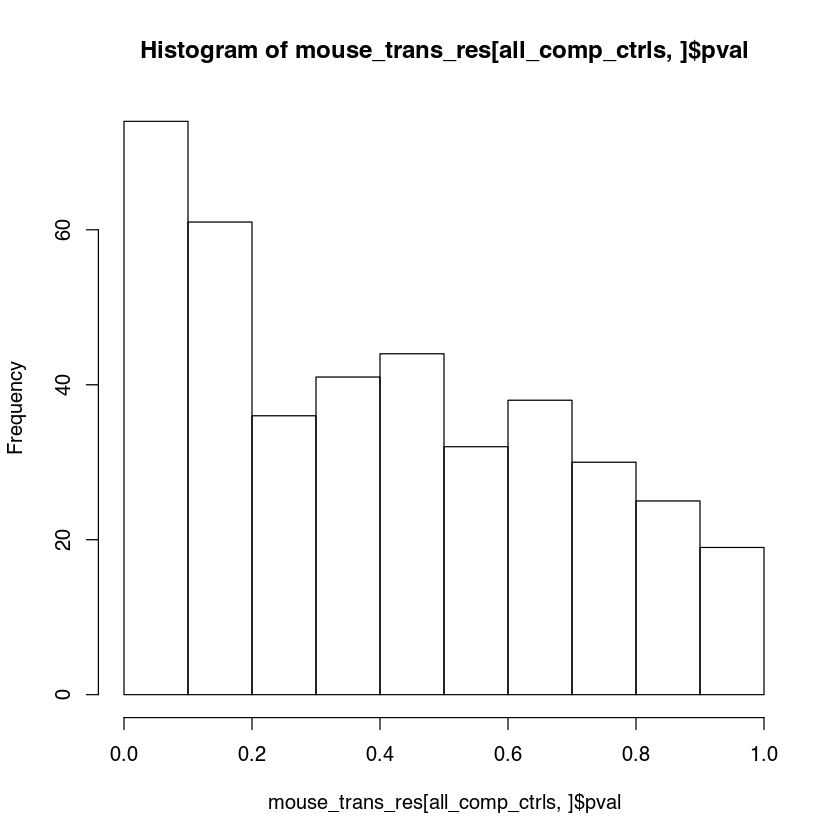

In [57]:
hist(mouse_trans_res[all_comp_ctrls,]$pval)

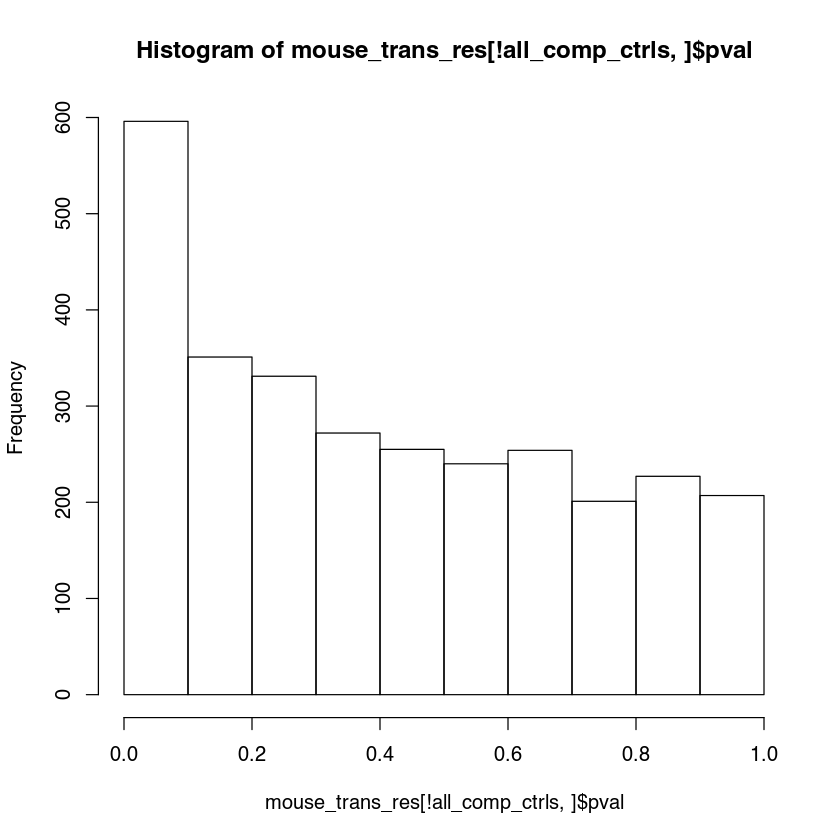

In [58]:
hist(mouse_trans_res[!all_comp_ctrls,]$pval)

In [59]:
write.table(mouse_trans_res, file = "../../../data/02__mpra/02__activs/mouse_trans_results.REP2_ONLY.txt", sep = "\t",
            quote = FALSE)